# Game Plot Embedding
- Input: cleaned_games.csv
- Output: game_plot_embeddings.npy, game_plot_metadata.csv
- Description: 게임 줄거리 텍스트를 BERT 임베딩으로 변환하고, 저장


In [15]:
!pip install -q transformers sentence-transformers
from tqdm import tqdm
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
import os

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Using device:", DEVICE)

✅ Using device: cpu


In [16]:
# ==========================================================
# 1. 데이터 불러오기 (GitHub raw URL 사용)
# ==========================================================
GAME_FILE_URL = "https://raw.githubusercontent.com/cup0927/2025Bigdata/main/game_dataset/cleaned_games.csv"
df = pd.read_csv(GAME_FILE_URL)
print("✅ Game data loaded:", df.shape)
print(df.head(2))

# ==========================================================
# 2. 임베딩 함수 정의 (BERT 사용)
# ==========================================================
def get_bert_embeddings(texts, model_name='bert-base-uncased', max_len=512):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name).to(DEVICE)
    model.eval()

    all_embeddings = []
    BATCH_SIZE = 32

    for i in tqdm(range(0, len(texts), BATCH_SIZE), desc="BERT Embedding"):
        batch_texts = texts[i:i + BATCH_SIZE]
        inputs = tokenizer(
            batch_texts,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=max_len
        ).to(DEVICE)

        with torch.no_grad():
            outputs = model(**inputs)
            embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()  # [CLS] 토큰 벡터
            all_embeddings.append(embeddings)

    return np.vstack(all_embeddings)

# ==========================================================
# 3. 스토리라인 임베딩 생성
# ==========================================================
texts = df["storyline"].fillna("No Storyline Available.").astype(str).tolist()
print("🎬 Storyline embedding start...")
storyline_embeddings = get_bert_embeddings(texts)
print("✅ Embedding completed:", storyline_embeddings.shape)

# ==========================================================
# 4. 로컬 저장 (Colab 내 디렉토리)
# ==========================================================
BASE_DIR = "/content/2025Bigdata/game_dataset/"
os.makedirs(BASE_DIR, exist_ok=True)

# 4-1. 임베딩 저장
np.save(BASE_DIR + "game_plot_embeddings.npy", storyline_embeddings)

# 4-2. game_id + title 매핑 저장
df[['game_id', 'title']].to_csv(BASE_DIR + "game_plot_metadata.csv", index=False)

print("✅ Game plot embeddings and metadata saved at:", BASE_DIR)


✅ Game data loaded: (5000, 13)
   game_id                     title                     slug released_date  \
0     3498        Grand Theft Auto V       grand-theft-auto-v    2013-09-17   
1     3328  The Witcher 3: Wild Hunt  the-witcher-3-wild-hunt    2015-05-18   

                                           platforms  \
0  ['pc', 'playstation 5', 'xbox series s/x', 'pl...   
1  ['playstation 5', 'xbox series s/x', 'macos', ...   

                                           storyline             genres  \
0  rockstar games went bigger since their previou...         ['action']   
1  the third game in a series it holds nothing ba...  ['action', 'rpg']   

   rating  rating_count  vote_exceptional_ratio  vote_recommended_ratio  \
0    4.47          7218                0.590265                0.326834   
1    4.64          7026                0.766667                0.163165   

   vote_meh_ratio  vote_skip_ratio  
0        0.063540         0.019362  
1        0.043137         0.027031  

BERT Embedding: 100%|██████████| 157/157 [2:45:34<00:00, 63.28s/it]


✅ Embedding completed: (5000, 768)
✅ Game plot embeddings and metadata saved at: /content/2025Bigdata/game_dataset/


* 유사도 분석

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

sim_scores = cosine_similarity(storyline_embeddings[0:1], storyline_embeddings)
top_indices = sim_scores[0].argsort()[::-1][1:6]  # 자기 자신 제외하고 상위 5개
print("\n🎮 First game similarity Top 5:")
for idx in top_indices:
    print(df.iloc[idx]['title'], f"(유사도: {sim_scores[0][idx]:.4f})")

* 클러스터링

In [18]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10, random_state=42)
labels = kmeans.fit_predict(storyline_embeddings)
df['cluster'] = labels
print(df[['title', 'cluster']].head(10))

                              title  cluster
0                Grand Theft Auto V        3
1          The Witcher 3: Wild Hunt        4
2                          Portal 2        6
3  Counter-Strike: Global Offensive        4
4                Tomb Raider (2013)        6
5                            Portal        9
6                     Left 4 Dead 2        9
7       The Elder Scrolls V: Skyrim        5
8             Red Dead Redemption 2        5
9                 BioShock Infinite        4


* 시각화(고차원 벡터 확인)



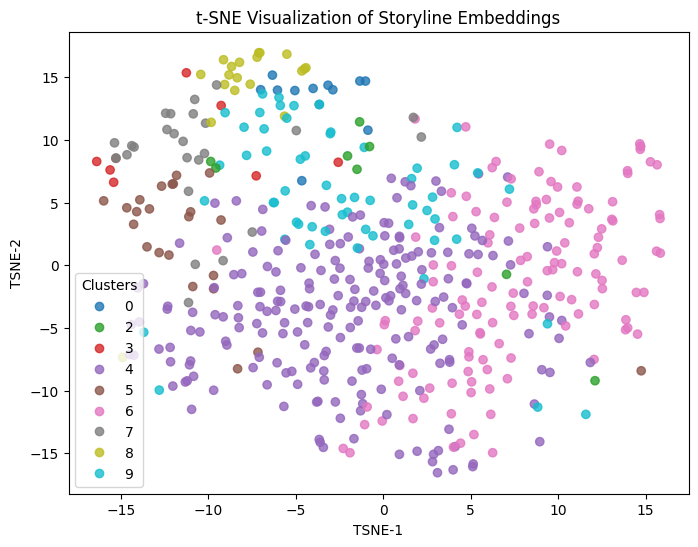

In [19]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, random_state=42)
emb_2d = tsne.fit_transform(storyline_embeddings[:500])  # 샘플 500개만
labels_sample = labels[:500]

plt.figure(figsize=(8,6))
scatter = plt.scatter(emb_2d[:,0], emb_2d[:,1], c=labels_sample, cmap='tab10', alpha=0.8)
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.title("t-SNE Visualization of Storyline Embeddings")
plt.xlabel("TSNE-1")
plt.ylabel("TSNE-2")
plt.show()